In [4]:
pip install tqdm



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


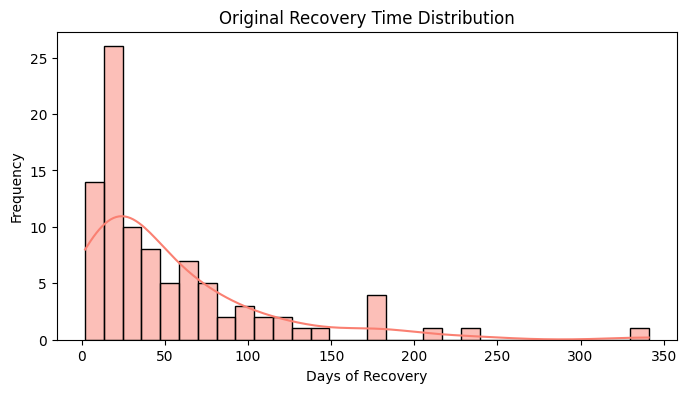

Summary Statistics (Before Transformation):
count     93.000000
mean      53.860215
std       57.829884
min        2.000000
25%       16.000000
50%       32.000000
75%       69.000000
max      341.000000
Name: dRecov, dtype: float64

Number of outliers detected: 7


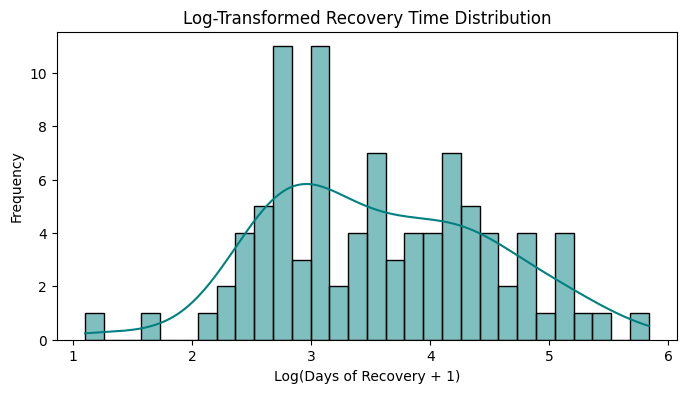

Summary Statistics (After Log Transformation):
count    93.000000
mean      3.571196
std       0.931863
min       1.098612
25%       2.833213
50%       3.496508
75%       4.248495
max       5.834811
Name: log_dRecov, dtype: float64


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your metadata
df = pd.read_csv("cleaned_output.csv")

# Plot the original recovery time distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['dRecov'], bins=30, kde=True, color="salmon")
plt.title("Original Recovery Time Distribution")
plt.xlabel("Days of Recovery")
plt.ylabel("Frequency")
plt.show()

# Display key statistics
print("Summary Statistics (Before Transformation):")
print(df['dRecov'].describe())

# Detect outliers using IQR
Q1 = df['dRecov'].quantile(0.25)
Q3 = df['dRecov'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['dRecov'] < lower_bound) | (df['dRecov'] > upper_bound)]
print(f"\nNumber of outliers detected: {len(outliers)}")

# Apply log transformation to reduce skew
df['log_dRecov'] = np.log1p(df['dRecov'])  # log(1 + x) to handle zero safely

# Plot the transformed recovery time
plt.figure(figsize=(8, 4))
sns.histplot(df['log_dRecov'], bins=30, kde=True, color="teal")
plt.title("Log-Transformed Recovery Time Distribution")
plt.xlabel("Log(Days of Recovery + 1)")
plt.ylabel("Frequency")
plt.show()

# Compare the new distribution
print("Summary Statistics (After Log Transformation):")
print(df['log_dRecov'].describe())


In [ ]:
# skip -------------------------------------------------
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load metadata and brain mask
df = pd.read_csv("cleaned_output.csv")
with h5py.File("brain_mask.h5", "r") as mask_file:
    brain_mask = mask_file["image_array"][:]  # shape = (X, Y, Z)

original_shape = brain_mask.shape  # This is the shape to reconstruct each volume

# Define a helper function to extract ROI stats
def extract_roi_stats(reconstructed_volume, roi_box):
    x0, x1, y0, y1, z0, z1 = roi_box
    roi = reconstructed_volume[x0:x1, y0:y1, z0:z1]
    stats = {
        "roi_mean": np.mean(roi),
        "roi_std": np.std(roi),
        "roi_min": np.min(roi),
        "roi_max": np.max(roi)
    }
    return stats

# Define a fixed ROI box around the center of the brain (adjust as needed)
X, Y, Z = original_shape
roi_box = (
    X//2 - 15, X//2 + 15,
    Y//2 - 15, Y//2 + 15,
    Z//2 - 5,  Z//2 + 5
)

# Initialize list to hold ROI features
roi_features = []

mri_volumes = {}

# Load overlayed MRI data
with h5py.File("25-brain_overlayed_new.h5", "r") as overlay_file:
    for subject_id in tqdm(df['ID'].astype(str).str.zfill(3), desc="Extracting ROI features"):
        if subject_id in overlay_file.keys():
            overlay_data = overlay_file[subject_id]['image_array'][:]
            
            # Reconstruct full 3D volume
            reconstructed_volume = np.zeros(original_shape)
            reconstructed_volume[brain_mask == 1] = overlay_data

            
            # Store 3D MRI volume for later use
            mri_volumes[subject_id] = reconstructed_volume
            
            # Extract ROI stats
            roi_stats = extract_roi_stats(reconstructed_volume, roi_box)
            roi_stats["subject_id"] = subject_id
            roi_features.append(roi_stats)

# Convert ROI stats to DataFrame
roi_df = pd.DataFrame(roi_features)

# Merge back with main dataframe
df['subject_id'] = df['ID'].astype(str).str.zfill(3)
df = df.merge(roi_df, on="subject_id", how="left")

# Save updated dataset
df.to_csv("clean_output_with_roi.csv", index=False)
print("ROI features extracted and added to dataset.")


Extracting ROI features: 100%|██████████| 93/93 [00:00<00:00, 221.64it/s]

ROI features extracted and added to dataset.


In [ ]:
# skip -===============================================
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load metadata with log-transformed dRecov
df = pd.read_csv("clean_output_with_roi.csv")

# Check if 'log_dRecov' already exists, otherwise create it
if 'log_dRecov' not in df.columns:
    df['log_dRecov'] = np.log1p(df['dRecov'])  # log(1 + x) avoids log(0) error


with h5py.File("brain_mask.h5", "r") as mask_file:
    brain_mask = mask_file["image_array"][:]
original_shape = brain_mask.shape

# Reconstruct all MRI volumes into a list
X_volumes = []
y_values = []

with h5py.File("25-brain_overlayed_new.h5", "r") as overlay_file:
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Reconstructing Volumes"):
        subject_id = str(row["ID"]).zfill(3)
        if subject_id in overlay_file:
            overlay_data = overlay_file[subject_id]["image_array"][:]
            vol = np.zeros(original_shape)
            vol[brain_mask == 1] = overlay_data
            X_volumes.append(vol.astype(np.float32))
            y_values.append(row["log_dRecov"])

# Convert to arrays
X_volumes = np.stack(X_volumes)
y_values = np.array(y_values, dtype=np.float32).reshape(-1, 1)

# Normalize volumes
X_volumes = (X_volumes - np.mean(X_volumes)) / np.std(X_volumes)

# Resize if needed (optional): e.g., X_volumes = torch.nn.functional.interpolate(...)


Reconstructing Volumes:   0%|          | 0/93 [00:00<?, ?it/s]

Reconstructing Volumes: 100%|██████████| 93/93 [00:00<00:00, 303.12it/s]


In [35]:
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load metadata and brain mask
df = pd.read_csv("cleaned_output.csv")
with h5py.File("brain_mask.h5", "r") as mask_file:
    brain_mask = mask_file["image_array"][:]  # shape = (X, Y, Z)

original_shape = brain_mask.shape  # This is the shape to reconstruct each volume

# Define a helper function to extract ROI stats
def extract_roi_stats(reconstructed_volume, roi_box):
    x0, x1, y0, y1, z0, z1 = roi_box
    roi = reconstructed_volume[x0:x1, y0:y1, z0:z1]
    stats = {
        "roi_mean": np.mean(roi),
        "roi_std": np.std(roi),
        "roi_min": np.min(roi),
        "roi_max": np.max(roi)
    }
    return stats

# Define a fixed ROI box around the center of the brain (adjust as needed)
X, Y, Z = original_shape
roi_box = (
    X//2 - 15, X//2 + 15,
    Y//2 - 15, Y//2 + 15,
    Z//2 - 5,  Z//2 + 5
)

# Initialize lists to hold ROI features and MRI volumes
roi_features = []
mri_volumes = {}

# Load overlayed MRI data and extract features
with h5py.File("25-brain_overlayed_new.h5", "r") as overlay_file:
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Reconstructing Volumes and Extracting ROI features"):
        subject_id = str(row["ID"]).zfill(3)
        if subject_id in overlay_file:
            overlay_data = overlay_file[subject_id]["image_array"][:]
            
            # Reconstruct full 3D volume
            reconstructed_volume = np.zeros(original_shape)
            reconstructed_volume[brain_mask == 1] = overlay_data
            
            # Store 3D MRI volume for later use
            mri_volumes[subject_id] = reconstructed_volume
            
            # Extract ROI stats
            roi_stats = extract_roi_stats(reconstructed_volume, roi_box)
            roi_stats["subject_id"] = subject_id
            roi_features.append(roi_stats)
            
# Convert ROI stats to DataFrame
roi_df = pd.DataFrame(roi_features)

# Merge back with main dataframe and handle log-transformed 'dRecov'
df['subject_id'] = df['ID'].astype(str).str.zfill(3)
df = df.merge(roi_df, on="subject_id", how="left")

# Check if 'log_dRecov' already exists, otherwise create it
if 'log_dRecov' not in df.columns:
    df['log_dRecov'] = np.log1p(df['dRecov'])  # log(1 + x) avoids log(0) error

# Reconstruct all MRI volumes into a list for later use in model training
X_volumes = []
y_values = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Reconstructing Volumes for Prediction"):
    subject_id = str(row["ID"]).zfill(3)
    if subject_id in mri_volumes:
        reconstructed_volume = mri_volumes[subject_id]
        X_volumes.append(reconstructed_volume.astype(np.float32))
        y_values.append(row["log_dRecov"])

# Convert to arrays
X_volumes = np.stack(X_volumes)
y_values = np.array(y_values, dtype=np.float32).reshape(-1, 1)

# Normalize volumes
X_volumes = (X_volumes - np.mean(X_volumes)) / np.std(X_volumes)

# Save updated dataset
df.to_csv("clean_output_with_roi.csv", index=False)
print("ROI features extracted, added to dataset, and MRI volumes prepared for prediction.")


Reconstructing Volumes and Extracting ROI features: 100%|██████████| 93/93 [00:00<00:00, 695.37it/s]
Reconstructing Volumes for Prediction: 100%|██████████| 93/93 [00:00<00:00, 627.78it/s]


ROI features extracted, added to dataset, and MRI volumes prepared for prediction.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Define updated CNN model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(32 * 16 * 19 * 16, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # [B, 16, 32, 38, 32]
        x = self.pool2(F.relu(self.conv2(x)))  # [B, 32, 16, 19, 16]
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Convert data to tensors
X_tensor = torch.tensor(X_volumes).unsqueeze(1)  # [B, 1, D=64, H=76, W=64]
y_tensor = torch.tensor(y_values, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize model, loss, and optimizer
model = CNN3D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # You can increase epochs later
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 1667.0331
Epoch 2, Loss: 42.2077
Epoch 3, Loss: 24.7923
Epoch 4, Loss: 13.6145
Epoch 5, Loss: 12.0826
Epoch 6, Loss: 9.8043
Epoch 7, Loss: 12.4854
Epoch 8, Loss: 10.2403
Epoch 9, Loss: 10.5225
Epoch 10, Loss: 10.3618


In [10]:
model.eval()
with torch.no_grad():
    preds = model(X_test)
    rmse = torch.sqrt(nn.MSELoss()(preds, y_test)).item()
print(f"3D CNN RMSE (log scale): {rmse}")


3D CNN RMSE (log scale): 0.9502866268157959


In [12]:
torch.save(model.state_dict(), "cnn3d_model.pt")


train test split

In [25]:
from sklearn.model_selection import train_test_split

# First split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

# Create datasets and loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=8)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}")


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8, 1, 64, 76, 64]

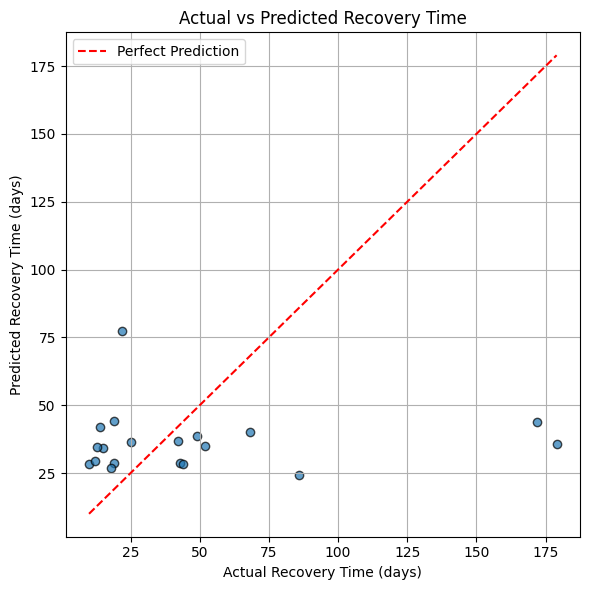

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy()
    y_true = y_test.squeeze().numpy()

# Convert from log scale to original scale
y_pred_days = np.expm1(y_pred)
y_true_days = np.expm1(y_true)

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true_days, y_pred_days, alpha=0.7, edgecolor='k')
plt.plot([y_true_days.min(), y_true_days.max()],
         [y_true_days.min(), y_true_days.max()],
         'r--', label="Perfect Prediction")
plt.xlabel("Actual Recovery Time (days)")
plt.ylabel("Predicted Recovery Time (days)")
plt.title("Actual vs Predicted Recovery Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step2: Pseudo RGB

In [19]:
import numpy as np

def extract_2_5D_patches(mri_volumes, patch_size=64):
    patches = []
    ids = []

    half = patch_size // 2

    for subject_id, volume in mri_volumes.items():
        D, H, W = volume.shape
        z_center, y_center, x_center = D // 2, H // 2, W // 2

        # Extract each orthogonal slice
        axial = volume[z_center, :, :]
        coronal = volume[:, y_center, :]
        sagittal = volume[:, :, x_center]

        # Crop centered patches
        axial_patch = axial[y_center-half:y_center+half, x_center-half:x_center+half]
        coronal_patch = coronal[z_center-half:z_center+half, x_center-half:x_center+half]
        sagittal_patch = sagittal[z_center-half:z_center+half, y_center-half:y_center+half]

        # Safety check: ensure all patches are correct size
        if axial_patch.shape != (patch_size, patch_size) or \
           coronal_patch.shape != (patch_size, patch_size) or \
           sagittal_patch.shape != (patch_size, patch_size):
            print(f"Skipping subject {subject_id} due to patch size mismatch.")
            continue

        # Stack into (3, patch_size, patch_size)
        patch_rgb = np.stack([axial_patch, coronal_patch, sagittal_patch], axis=0).astype(np.float32)

        # Normalize (optional)
        patch_rgb = (patch_rgb - np.mean(patch_rgb)) / np.std(patch_rgb)

        patches.append(patch_rgb)
        ids.append(subject_id)

    return np.array(patches), ids


In [20]:
patch_data, subject_ids = extract_2_5D_patches(mri_volumes, patch_size=64)

print("2.5D patch dataset shape:", patch_data.shape)  # Expect: (N, 3, 64, 64)


2.5D patch dataset shape: (93, 3, 64, 64)


## Regression (ie predicting recovery time)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN2_5D(nn.Module):
    def __init__(self, num_classes=1):  # Use num_classes=1 for regression
        super(CNN2_5D, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 64 → 32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2)  # 32 → 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2)  # 16 → 8

        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))

        if self.fc2.out_features == 1:
            return self.fc2(x)  # Regression output
        else:
            return F.log_softmax(self.fc2(x), dim=1)  # Classification


## Classification ( ie long short recovery)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN2_5D(nn.Module):
    def __init__(self, num_classes=2):  # Use num_classes=1 for regression
        super(CNN2_5D, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 64 → 32

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2)  # 32 → 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2)  # 16 → 8

        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))

        if self.fc2.out_features == 1:
            return self.fc2(x)  # Regression output
        else:
            return F.log_softmax(self.fc2(x), dim=1)  # Classification


### train

c:\Users\Intel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Intel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 2648.8788, Val Loss: 757.5710
Epoch 2, Train Loss: 1414.6043, Val Loss: 1095.2248
Epoch 3, Train Loss: 915.9861, Val Loss: 784.3779
Epoch 4, Train Loss: 801.9557, Val Loss: 591.1346
Epoch 5, Train Loss: 825.1911, Val Loss: 827.2582
Epoch 6, Train Loss: 875.3909, Val Loss: 584.3939
Epoch 7, Train Loss: 803.4817, Val Loss: 1098.3914
Epoch 8, Train Loss: 886.8675, Val Loss: 587.9606
Epoch 9, Train Loss: 794.9021, Val Loss: 739.9371
Epoch 10, Train Loss: 813.1688, Val Loss: 796.4746


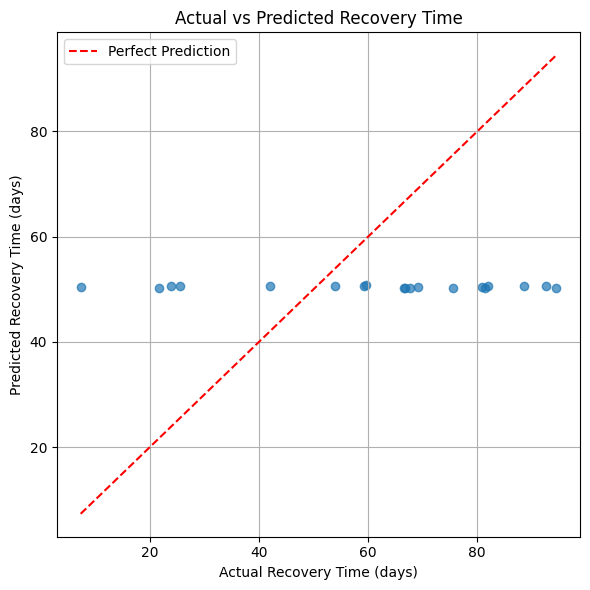

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Sample data placeholder
# Replace with your actual 2.5D patch dataset and targets
X_patches = torch.rand(93, 3, 64, 64)  # (samples, channels, H, W)
y_values = torch.rand(93) * 100  # Example recovery times in days

# CNN Model
class CNN2_5D(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN2_5D, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Dataset and DataLoader
dataset = TensorDataset(X_patches, y_values)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

# Initialize model
model = CNN2_5D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(X), y).item() for X, y in val_loader) / len(val_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Final Evaluation: Actual vs. Predicted
model.eval()
X_val, y_val = next(iter(DataLoader(val_ds, batch_size=len(val_ds))))
with torch.no_grad():
    y_pred = model(X_val).squeeze()

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Recovery Time (days)")
plt.ylabel("Predicted Recovery Time (days)")
plt.title("Actual vs Predicted Recovery Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# tring multiple CNN

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# --------------------------------------------
# 1. Define All Candidate Models
# --------------------------------------------
class CNN2_5D(nn.Module):
    def __init__(self):
        super(CNN2_5D, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(32 * 16 * 19 * 16, 128)  # Adjusted for your input shape
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class CNN3_1(nn.Module):
    def __init__(self):
        super(CNN3_1, self).__init__()
        
        # First convolution + ReLU
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)

        # Second convolution + Swish (SiLU)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)

        # Third convolution + ReLU
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(2)

        # Update input size to match your volume (assumed shape after pooling: [64, 8, 9, 8])
        self.fc1 = nn.Linear(64 * 8 * 9 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     # ReLU
        x = self.pool2(F.silu(self.conv2(x)))     # Swish (SiLU)
        x = self.pool3(F.relu(self.conv3(x)))     # ReLU

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)




In [ ]:
def train_and_evaluate_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                pred = model(X_val)
                val_preds.extend(pred.squeeze().tolist())
                val_targets.extend(y_val.squeeze().tolist())

        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Val RMSE: {val_rmse:.4f}")

    return val_rmse


model_dict = {
    "2.5D CNN": CNN2_5D,
    "3D CNN": CNN3D,
    # "YourModelName": YourModelClass,
}
# Only use 2.5D (2D CNN) for 2D data
cnn_2d_models = {
    "2.5D CNN": CNN2_5D,
}

# Only use 3D CNNs for 3D input
cnn_3d_models = {
    "3D CNN": CNN3D,
}

cnn_3d1_models = {
    "3D CNN1": CNN3_1,
}

def run_all_models(X_tensor, y_tensor, is_3D=True, model_dict=None):
    results = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=8)

    for name, model_class in model_dict.items():
        print(f"\n🧠 Running {name}...")
        model = model_class()
        rmse = train_and_evaluate_model(model, train_loader, val_loader)
        results[name] = rmse

    print("\n📊 Final RMSE Scores:")
    for name, score in results.items():
        print(f"{name}: {score:.4f}")
    return results



In [51]:
import torch
import numpy as np

# --- Assuming you already have these from your earlier code ---
# mri_volumes = {subject_id: 3D volume}
# df = pd.read_csv("cleaned_output.csv") with 'log_dRecov' column
# brain_mask is available for reconstruction
# original_shape = brain_mask.shape

# Create input data lists
X_volumes = []
patch_dataset = []
y_values = []

# Define the center-slice patch extraction
for _, row in df.iterrows():
    subject_id = str(row["ID"]).zfill(3)
    if subject_id in mri_volumes:
        vol = mri_volumes[subject_id]
        X_volumes.append(vol.astype(np.float32))
        y_values.append(row["log_dRecov"])

        # --- 2.5D patch extraction ---
        x_mid, y_mid, z_mid = np.array(vol.shape) // 2
        axial = vol[:, :, z_mid][:64, :64]
        sagittal = vol[x_mid, :, :][:64, :64]
        coronal = vol[:, y_mid, :][:64, :64]
        patch = np.stack([axial, sagittal, coronal], axis=0)
        patch_dataset.append(patch)

# --- Convert to tensors ---
X_volumes = np.stack(X_volumes)  # shape: (N, D, H, W)
patch_dataset = np.stack(patch_dataset)  # shape: (N, 3, 64, 64)
y_values = np.array(y_values).reshape(-1, 1)

# Normalize 3D volumes
X_volumes = (X_volumes - np.mean(X_volumes)) / np.std(X_volumes)

# Final tensors
X_2_5d_tensor = torch.tensor(patch_dataset, dtype=torch.float32)         # shape: (N, 3, 64, 64)
X_3d_tensor = torch.tensor(X_volumes, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, D, H, W)
y_tensor = torch.tensor(y_values, dtype=torch.float32)                   # shape: (N, 1)



In [52]:
# For 2.5D patch model (shape: [N, 3, 64, 64])
results_2d = run_all_models(X_2_5d_tensor, y_tensor, is_3D=False, model_dict=cnn_2d_models)

# For 3D model (shape: [N, 1, D, H, W])
results_3d = run_all_models(X_3d_tensor, y_tensor, is_3D=True, model_dict=cnn_3d_models)

# For 3.1D model (shape: [N, 1, D, H, W])
results_3d1 = run_all_models(X_3d_tensor, y_tensor, is_3D=True, model_dict=cnn_3d1_models)




🧠 Running 2.5D CNN...
Epoch 1, Train Loss: 103.1257, Val RMSE: 2.4477
Epoch 2, Train Loss: 23.7006, Val RMSE: 0.8376
Epoch 3, Train Loss: 17.7185, Val RMSE: 0.9574
Epoch 4, Train Loss: 21.1418, Val RMSE: 0.8328
Epoch 5, Train Loss: 16.7123, Val RMSE: 1.7755
Epoch 6, Train Loss: 17.8818, Val RMSE: 0.9755
Epoch 7, Train Loss: 15.9088, Val RMSE: 0.8642
Epoch 8, Train Loss: 9.3315, Val RMSE: 0.8273
Epoch 9, Train Loss: 7.2886, Val RMSE: 0.8376
Epoch 10, Train Loss: 7.2543, Val RMSE: 1.0424

📊 Final RMSE Scores:
2.5D CNN: 1.0424

🧠 Running 3D CNN...
Epoch 1, Train Loss: 2784.8523, Val RMSE: 1.9207
Epoch 2, Train Loss: 38.9524, Val RMSE: 1.4115
Epoch 3, Train Loss: 19.7492, Val RMSE: 1.1162
Epoch 4, Train Loss: 17.7363, Val RMSE: 0.9454
Epoch 5, Train Loss: 21.1305, Val RMSE: 0.9816
Epoch 6, Train Loss: 12.8311, Val RMSE: 1.0808
Epoch 7, Train Loss: 11.6901, Val RMSE: 0.9207
Epoch 8, Train Loss: 12.1359, Val RMSE: 0.9543
Epoch 9, Train Loss: 10.5223, Val RMSE: 0.9076
Epoch 10, Train Loss: 9

In [53]:
results_3d1 = run_all_models(X_3d_tensor, y_tensor, is_3D=True, model_dict=cnn_3d1_models)


🧠 Running 3D CNN1...
Epoch 1, Train Loss: 61.9369, Val RMSE: 1.6128
Epoch 2, Train Loss: 17.1192, Val RMSE: 0.9932
Epoch 3, Train Loss: 11.1398, Val RMSE: 0.8056
Epoch 4, Train Loss: 8.9054, Val RMSE: 0.8712
Epoch 5, Train Loss: 8.7303, Val RMSE: 0.9400
Epoch 6, Train Loss: 11.8477, Val RMSE: 0.9592
Epoch 7, Train Loss: 10.1020, Val RMSE: 0.8541
Epoch 8, Train Loss: 8.2899, Val RMSE: 1.0965
Epoch 9, Train Loss: 12.3867, Val RMSE: 0.9169
Epoch 10, Train Loss: 7.4477, Val RMSE: 0.8133

📊 Final RMSE Scores:
3D CNN1: 0.8133


In [54]:
results_3d = run_all_models(X_3d_tensor, y_tensor, is_3D=True, model_dict=cnn_3d_models)


🧠 Running 3D CNN...
Epoch 1, Train Loss: 2377.9154, Val RMSE: 2.3484
Epoch 2, Train Loss: 50.8167, Val RMSE: 1.6961
Epoch 3, Train Loss: 23.7694, Val RMSE: 1.3044
Epoch 4, Train Loss: 18.5253, Val RMSE: 1.0594
Epoch 5, Train Loss: 14.4926, Val RMSE: 0.9650
Epoch 6, Train Loss: 13.5743, Val RMSE: 1.0094
Epoch 7, Train Loss: 11.9236, Val RMSE: 0.9685
Epoch 8, Train Loss: 9.6835, Val RMSE: 0.9486
Epoch 9, Train Loss: 8.6937, Val RMSE: 0.9291
Epoch 10, Train Loss: 8.5323, Val RMSE: 0.9255

📊 Final RMSE Scores:
3D CNN: 0.9255


NameError: name 'y_pred_3d' is not defined

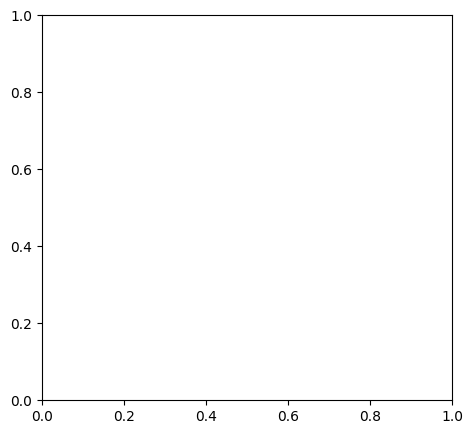

In [55]:
import matplotlib.pyplot as plt

# Replace these with your actual values
# y_val: actual recovery time (in days)
# y_pred_3d: predictions from 3D CNN
# y_pred_3d1: predictions from CNN3.1 (ReLU + Swish)
# y_pred_2d: predictions from 2.5D CNN

plt.figure(figsize=(18, 5))

# Plot for 3D CNN
plt.subplot(1, 3, 1)
plt.scatter(y_val, y_pred_3d, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Recovery Time (days)")
plt.ylabel("Predicted Recovery Time (days)")
plt.title("3D CNN (Baseline)")
plt.legend()
plt.grid(True)

# Plot for CNN3.1
plt.subplot(1, 3, 2)
plt.scatter(y_val, y_pred_3d1, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Recovery Time (days)")
plt.ylabel("Predicted Recovery Time (days)")
plt.title("CNN3.1 (ReLU + Swish)")
plt.legend()
plt.grid(True)

# Plot for 2.5D CNN
plt.subplot(1, 3, 3)
plt.scatter(y_val, y_pred_2d, alpha=0.7)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Recovery Time (days)")
plt.ylabel("Predicted Recovery Time (days)")
plt.title("2.5D CNN")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
